## Homework

> Note: sometimes your answer doesn't match one of 
> the options exactly. That's fine. 
> Select the option that's closest to your solution.

In this dataset our desired target for classification task will be `converted` variable - has the client signed up to the platform or not. 

### Data preparation

* Check if the missing values are presented in the features.
* If there are missing values:
    * For caterogiral features, replace them with 'NA'
    * For numerical features, replace with with 0.0 

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`


### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score (aka prediction) and compute the AUC with the `y` variable as ground truth.
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['balance']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `lead_score`
- `number_of_courses_viewed`
- `interaction_count`
- `annual_income`

In [22]:
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold


In [23]:
df = pd.read_csv('../data/course_lead_scoring.csv')
print("Dataset columns:")
print(df.columns.tolist())
print("\nDataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

Dataset columns:
['lead_source', 'industry', 'number_of_courses_viewed', 'annual_income', 'employment_status', 'location', 'interaction_count', 'lead_score', 'converted']

Dataset shape: (1462, 9)

First few rows:
    lead_source    industry  number_of_courses_viewed  annual_income  \
0      paid_ads         NaN                         1        79450.0   
1  social_media      retail                         1        46992.0   
2        events  healthcare                         5        78796.0   
3      paid_ads      retail                         2        83843.0   
4      referral   education                         3        85012.0   

  employment_status       location  interaction_count  lead_score  converted  
0        unemployed  south_america                  4        0.94          1  
1          employed  south_america                  1        0.80          0  
2        unemployed      australia                  3        0.69          1  
3               NaN      australia   

In [24]:
numerical = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']
print("Missing values in numerical columns:")
for col in numerical:
    missing = df[col].isnull().sum()
    print(f'{col}: {missing} ({missing/len(df)*100:.1f}%)')

print("\nSample of annual_income column:")
print(df['annual_income'].describe())

Missing values in numerical columns:
lead_score: 0 (0.0%)
number_of_courses_viewed: 0 (0.0%)
interaction_count: 0 (0.0%)
annual_income: 181 (12.4%)

Sample of annual_income column:
count      1281.000000
mean      59886.273224
std       15070.140389
min       13929.000000
25%       49698.000000
50%       60148.000000
75%       69639.000000
max      109899.000000
Name: annual_income, dtype: float64


In [25]:
df_train = pd.read_csv('../data/course_lead_scoring.csv')
numerical = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']
for col in numerical:
    df_train[col] = df_train[col].fillna(0.0)

print("ROC AUC scores for numerical variables:")
for col in numerical:
    auc = roc_auc_score(df_train['converted'], df_train[col])
    if auc < 0.5:
        auc = roc_auc_score(df_train['converted'], -df_train[col])
        print(f'{col}: {auc:.4f} (inverted)')
    else:
        print(f'{col}: {auc:.4f}')

ROC AUC scores for numerical variables:
lead_score: 0.6148
number_of_courses_viewed: 0.7608
interaction_count: 0.7223
annual_income: 0.5426


### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.32
- 0.52
- 0.72
- 0.92

In [26]:
df = pd.read_csv('../data/course_lead_scoring.csv')

print("Missing values by column:")
print(df.isnull().sum())
print("\nData types:")
print(df.dtypes)

categorical = ['lead_source', 'industry', 'employment_status', 'location']
numerical = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']

for col in categorical:
    df[col] = df[col].fillna('NA')

for col in numerical:
    df[col] = df[col].fillna(0.0)

print("\nMissing values after cleaning:")
print(df.isnull().sum())

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

print(f"\nData split sizes:")
print(f"Train: {len(df_train)} ({len(df_train)/len(df)*100:.0f}%)")
print(f"Validation: {len(df_val)} ({len(df_val)/len(df)*100:.0f}%)")
print(f"Test: {len(df_test)} ({len(df_test)/len(df)*100:.0f}%)")

df_train_features = df_train.drop('converted', axis=1)
df_val_features = df_val.drop('converted', axis=1)

y_train = df_train['converted'].values
y_val = df_val['converted'].values

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(df_train_features.to_dict(orient='records'))
X_val = dv.transform(df_val_features.to_dict(orient='records'))

print(f"\nFeature matrix shapes:")
print(f"X_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print(f'\nValidation AUC: {auc:.3f}')

Missing values by column:
lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

Data types:
lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

Missing values after cleaning:
lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

Data s

### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.145
* 0.345
* 0.545
* 0.745

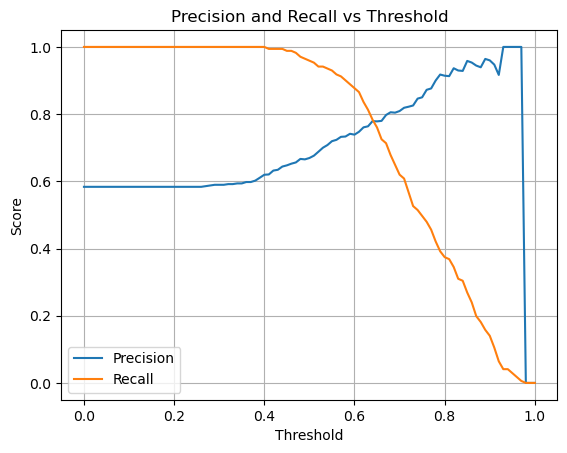

Precision and Recall intersect at threshold: 0.640 (Precision: 0.779, Recall: 0.784)
Precision and Recall intersect at threshold: 0.980 (Precision: 0.000, Recall: 0.000)
Precision and Recall intersect at threshold: 0.990 (Precision: 0.000, Recall: 0.000)
Precision and Recall intersect at threshold: 1.000 (Precision: 0.000, Recall: 0.000)


In [27]:
thresholds = np.arange(0.0, 1.01, 0.01)
precisions = []
recalls = []
for t in thresholds:
    y_pred_thresholded = (y_pred >= t).astype(int)
    tp = ((y_val == 1) & (y_pred_thresholded == 1)).sum()
    fp = ((y_val == 0) & (y_pred_thresholded == 1)).sum()
    fn = ((y_val == 1) & (y_pred_thresholded == 0)).sum()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    precisions.append(precision)
    recalls.append(recall)
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid()
plt.show()

for t, p, r in zip(thresholds, precisions, recalls):
    if abs(p - r) < 0.01:
        print(f'Precision and Recall intersect at threshold: {t:.3f} (Precision: {p:.3f}, Recall: {r:.3f})')


### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.14
- 0.34
- 0.54
- 0.74

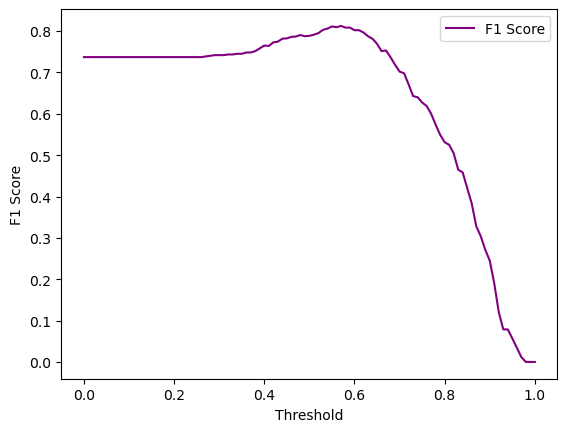

Max F1 score: 0.812 at threshold: 0.570


In [28]:
f1_scores = []
for p, r in zip(precisions, recalls):
    if (p + r) == 0:
        f1 = 0
    else:
        f1 = 2 * (p * r) / (p + r)
    f1_scores.append(f1)
plt.plot(thresholds, f1_scores, label='F1 Score', color='purple')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

max_f1 = max(f1_scores)
best_threshold = thresholds[f1_scores.index(max_f1)]
print(f'Max F1 score: {max_f1:.3f} at threshold: {best_threshold:.3f}')


### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06
- 0.36

In [29]:
df_full_train_features = df_full_train.drop('converted', axis=1)
y_full_train = df_full_train['converted']

kf = KFold(n_splits=5, shuffle=True, random_state=1)
auc_scores = []

print("5-Fold Cross Validation Results:")
fold = 1

for train_index, val_index in kf.split(df_full_train_features):
    X_train_fold = df_full_train_features.iloc[train_index]
    X_val_fold = df_full_train_features.iloc[val_index]
    y_train_fold = y_full_train.iloc[train_index]
    y_val_fold = y_full_train.iloc[val_index]
    dv_fold = DictVectorizer(sparse=False)
    X_train_encoded = dv_fold.fit_transform(X_train_fold.to_dict(orient='records'))
    X_val_encoded = dv_fold.transform(X_val_fold.to_dict(orient='records'))
    model_fold = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model_fold.fit(X_train_encoded, y_train_fold)
    y_pred_fold = model_fold.predict_proba(X_val_encoded)[:, 1]
    auc_fold = roc_auc_score(y_val_fold, y_pred_fold)
    auc_scores.append(auc_fold)
    
    print(f"Fold {fold} AUC: {auc_fold:.4f}")
    fold += 1

mean_auc = np.mean(auc_scores)
std_auc = np.std(auc_scores)

print(f"\nCross-Validation Results:")
print(f"Mean AUC: {mean_auc:.4f}")
print(f"Standard Deviation: {std_auc:.4f}")
print(f"AUC scores: {[round(score, 4) for score in auc_scores]}")

5-Fold Cross Validation Results:
Fold 1 AUC: 0.8061
Fold 2 AUC: 0.8714
Fold 3 AUC: 0.7754
Fold 4 AUC: 0.8018
Fold 5 AUC: 0.8558

Cross-Validation Results:
Mean AUC: 0.8221
Standard Deviation: 0.0358
AUC scores: [0.8061, 0.8714, 0.7754, 0.8018, 0.8558]
Fold 5 AUC: 0.8558

Cross-Validation Results:
Mean AUC: 0.8221
Standard Deviation: 0.0358
AUC scores: [0.8061, 0.8714, 0.7754, 0.8018, 0.8558]


### Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.000001, 0.001, 1]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.000001
- 0.001
- 1

In [30]:
C_values = [0.000001, 0.001, 1]
max_mean_auc = 0
best_C = None
results = []

print("Hyperparameter Tuning Results:")
print("=" * 40)

for C in C_values:
    auc_scores = []
    
    for train_index, val_index in kf.split(df_full_train_features):
        X_train_fold = df_full_train_features.iloc[train_index]
        X_val_fold = df_full_train_features.iloc[val_index]
        y_train_fold = y_full_train.iloc[train_index]
        y_val_fold = y_full_train.iloc[val_index]
        dv_fold = DictVectorizer(sparse=False)
        X_train_encoded = dv_fold.fit_transform(X_train_fold.to_dict(orient='records'))
        X_val_encoded = dv_fold.transform(X_val_fold.to_dict(orient='records'))
        model_fold = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model_fold.fit(X_train_encoded, y_train_fold)
        y_pred_fold = model_fold.predict_proba(X_val_encoded)[:, 1]
        auc_fold = roc_auc_score(y_val_fold, y_pred_fold)
        auc_scores.append(auc_fold)
    mean_auc = np.mean(auc_scores)
    std_auc = np.std(auc_scores)
    
    results.append({
        'C': C,
        'mean_auc': mean_auc,
        'std_auc': std_auc,
        'auc_scores': auc_scores
    })
    
    print(f"C={C}: Mean AUC={mean_auc:.3f}, Std={std_auc:.3f}")
    
    if mean_auc > max_mean_auc:
        max_mean_auc = mean_auc     
        best_C = C

print("=" * 40)
print(f"Best C value: {best_C}")
print(f"Best mean AUC: {max_mean_auc:.3f}")

print("\nDetailed Results:")
for result in results:
    print(f"C={result['C']}: {result['auc_scores']}")
    print(f"  Mean: {result['mean_auc']:.4f}, Std: {result['std_auc']:.4f}")
    print()

Hyperparameter Tuning Results:
C=1e-06: Mean AUC=0.560, Std=0.024
C=0.001: Mean AUC=0.867, Std=0.029
C=1: Mean AUC=0.822, Std=0.036
Best C value: 0.001
Best mean AUC: 0.867

Detailed Results:
C=1e-06: [0.5572098563239782, 0.5191961842208147, 0.5894909688013137, 0.5582191780821917, 0.5769230769230769]
  Mean: 0.5602, Std: 0.0238

C=0.001: [0.8608650338718081, 0.8967081085307685, 0.822816482915005, 0.8539850560398504, 0.9000154774802662]
  Mean: 0.8669, Std: 0.0287

C=1: [0.8060745924216483, 0.8713738368910783, 0.7754320118852139, 0.8018368617683685, 0.8558272713202291]
  Mean: 0.8221, Std: 0.0358

C=0.001: Mean AUC=0.867, Std=0.029
C=1: Mean AUC=0.822, Std=0.036
Best C value: 0.001
Best mean AUC: 0.867

Detailed Results:
C=1e-06: [0.5572098563239782, 0.5191961842208147, 0.5894909688013137, 0.5582191780821917, 0.5769230769230769]
  Mean: 0.5602, Std: 0.0238

C=0.001: [0.8608650338718081, 0.8967081085307685, 0.822816482915005, 0.8539850560398504, 0.9000154774802662]
  Mean: 0.8669, Std: 0